# Autores
- Alisson Santos da Silveira
- Felipe Pereira de Castro
- Gabriel Sperb Stoffel
- Karina Murta Starling Hayashi

# Projeto de Análise de PIB e População por Estado

Este projeto realiza a análise de dados de PIB e população dos estados brasileiros, gerando gráficos comparativos e previsões de PIB per capita. Os dados são obtidos de fontes externas, transformados e armazenados em um banco de dados PostgreSQL.

## Funcionalidades

Neste notebook foi feito a análise exploratória dos dados anterior a criação do script de ETL. Usamos o Jupyter e o Colab como playground para testar e entender o comportamento dos dados nos quais queriamos trabalhar, gerando insights e gráficos, para que assim criassemos o pipeline completo.

- **Obtenção de Dados**:
  - PIB: Obtido via API do IBGE no formato **JSON** (semi-estruturados).
  - População: Arquivo Excel (**tabela - CSV - estruturado**) baixado de um link do Google Drive.

- **Transformação de Dados**:
  - Dados de PIB e população são processados para incluir apenas os anos e estados relevantes.
  - Cálculo do PIB per capita com base nos dados de PIB e população.

- **Geração de Gráficos**:
  - Gráficos comparativos de PIB, população e PIB per capita por estado e ano.
  - Previsões de PIB per capita até 2025 utilizando regressão linear.

## Dependências
- Bibliotecas Python:
  - Pandas
  - Matplotlib
  - NumPy
  - Scikit-learn
  - Requests
  - SQLAlchemy
  - Psycopg2
  - Openpyxl
  - Seaborn


# Instalação das bibliotecas

Aqui garantimos que todas as dependência de bibliotecas estejam instaladas e prontas para uso durante o desenvolvimento do notebook.

In [1]:
%pip install pandas
%pip install requests
%pip install matplotlib
%pip install seaborn
%pip install openpyxl
%pip install plotly
%pip install scikit-learn

# PIB

Informações obtidas a partir do agregado de dados do IBGE (https://servicodados.ibge.gov.br/api/docs/agregados?versao=3#api-bq). Através do Query Builder foram utilizados os seguinte parametros para montar a URI:

*   Pesquisa: Produto interno Bruto dos Municípios
*   Agregado: 5938
*   Variáveis: 37
*   Períodos: Anos separados poor pipe |, exemplo: 2020|2021|2022
*   Nível Geografico: N3
*   Localidades: Todos


## Explorando inicial dos dados

In [2]:
url_pib = 'https://servicodados.ibge.gov.br/api/v3/agregados/5938/periodos/2019|2020|2021/variaveis/37?localidades=N3[all]'

In [3]:
import requests

response_pib = requests.get(url_pib)
response_pib

<Response [200]>

In [4]:
response_pib.json()[0]['resultados'][0]['series'][:2]

[{'localidade': {'id': '11',
   'nivel': {'id': 'N3', 'nome': 'Unidade da Federação'},
   'nome': 'Rondônia'},
  'serie': {'2019': '47091336', '2020': '51598741', '2021': '58170096'}},
 {'localidade': {'id': '12',
   'nivel': {'id': 'N3', 'nome': 'Unidade da Federação'},
   'nome': 'Acre'},
  'serie': {'2019': '15630017', '2020': '16476371', '2021': '21374440'}}]

In [5]:
response_pib.json()[0]['resultados'][0]['series'][0]

{'localidade': {'id': '11',
  'nivel': {'id': 'N3', 'nome': 'Unidade da Federação'},
  'nome': 'Rondônia'},
 'serie': {'2019': '47091336', '2020': '51598741', '2021': '58170096'}}

In [6]:
response_pib.json()[0]['resultados'][0]['series'][0]['localidade']

{'id': '11',
 'nivel': {'id': 'N3', 'nome': 'Unidade da Federação'},
 'nome': 'Rondônia'}

In [7]:
response_pib.json()[0]['resultados'][0]['series'][0]['localidade']['nome']

'Rondônia'

In [8]:
response_pib.json()[0]['resultados'][0]['series'][0]['serie']

{'2019': '47091336', '2020': '51598741', '2021': '58170096'}

In [9]:
response_pib.json()[0]['resultados'][0]['series'][0]['serie']['2019']

'47091336'

In [10]:
response_pib.json()[0]['resultados'][0]['series'][0]

{'localidade': {'id': '11',
  'nivel': {'id': 'N3', 'nome': 'Unidade da Federação'},
  'nome': 'Rondônia'},
 'serie': {'2019': '47091336', '2020': '51598741', '2021': '58170096'}}

## Load DataFrame

In [11]:
from datetime import datetime

ano_atual = datetime.now().year
ano_atual

2025

In [12]:
ultimos_anos = [str(i) for i in range(ano_atual - 20, ano_atual + 1)]
ultimos_anos

['2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022',
 '2023',
 '2024',
 '2025']

In [13]:
anos = '|'.join([str(i) for i in range(ano_atual - 20, ano_atual + 1)])
anos

'2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|2021|2022|2023|2024|2025'

In [14]:
url_pib = 'https://servicodados.ibge.gov.br/api/v3/agregados/5938/periodos/{anos}/variaveis/37?localidades=N3[all]'
url_pib = url_pib.format(anos=anos)
url_pib

'https://servicodados.ibge.gov.br/api/v3/agregados/5938/periodos/2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|2021|2022|2023|2024|2025/variaveis/37?localidades=N3[all]'

In [15]:
import requests

response_pib = requests.get(url_pib)

In [16]:
data_pib = response_pib.json()[0]['resultados'][0]['series']
data_pib[:2]

[{'localidade': {'id': '11',
   'nivel': {'id': 'N3', 'nome': 'Unidade da Federação'},
   'nome': 'Rondônia'},
  'serie': {'2005': '12511821',
   '2006': '13054713',
   '2007': '14438376',
   '2008': '17285542',
   '2009': '19725010',
   '2010': '23907887',
   '2011': '27574714',
   '2012': '30112720',
   '2013': '31121413',
   '2014': '34030982',
   '2015': '36563333',
   '2016': '39460359',
   '2017': '43516147',
   '2018': '44913978',
   '2019': '47091336',
   '2020': '51598741',
   '2021': '58170096'}},
 {'localidade': {'id': '12',
   'nivel': {'id': 'N3', 'nome': 'Unidade da Federação'},
   'nome': 'Acre'},
  'serie': {'2005': '4300581',
   '2006': '4661807',
   '2007': '5458172',
   '2008': '6410255',
   '2009': '7407821',
   '2010': '8342356',
   '2011': '8949434',
   '2012': '10137925',
   '2013': '11473930',
   '2014': '13458698',
   '2015': '13622802',
   '2016': '13754240',
   '2017': '14272941',
   '2018': '15331123',
   '2019': '15630017',
   '2020': '16476371',
   '2021':

In [17]:
import pandas as pd
import json
from io import StringIO

df_pib = pd.read_json(StringIO(json.dumps(data_pib)), orient='records')
df_pib.head()

,localidade,serie
0,"{'id': '11', 'nivel': {'id': 'N3', 'nome': 'Un...","{'2005': '12511821', '2006': '13054713', '2007..."
1,"{'id': '12', 'nivel': {'id': 'N3', 'nome': 'Un...","{'2005': '4300581', '2006': '4661807', '2007':..."
2,"{'id': '13', 'nivel': {'id': 'N3', 'nome': 'Un...","{'2005': '33980877', '2006': '39933213', '2007..."
3,"{'id': '14', 'nivel': {'id': 'N3', 'nome': 'Un...","{'2005': '3193430', '2006': '3802452', '2007':..."
4,"{'id': '15', 'nivel': {'id': 'N3', 'nome': 'Un...","{'2005': '40522893', '2006': '45983027', '2007..."


## Extraindo os dados

In [18]:
df_pib['estado'] = df_pib['localidade'].apply(lambda row: row['nome'])
df_pib.head()

,localidade,serie,estado
0,"{'id': '11', 'nivel': {'id': 'N3', 'nome': 'Un...","{'2005': '12511821', '2006': '13054713', '2007...",Rondônia
1,"{'id': '12', 'nivel': {'id': 'N3', 'nome': 'Un...","{'2005': '4300581', '2006': '4661807', '2007':...",Acre
2,"{'id': '13', 'nivel': {'id': 'N3', 'nome': 'Un...","{'2005': '33980877', '2006': '39933213', '2007...",Amazonas
3,"{'id': '14', 'nivel': {'id': 'N3', 'nome': 'Un...","{'2005': '3193430', '2006': '3802452', '2007':...",Roraima
4,"{'id': '15', 'nivel': {'id': 'N3', 'nome': 'Un...","{'2005': '40522893', '2006': '45983027', '2007...",Pará


In [19]:
df_pib['serie'].head()

,serie
0,"{'2005': '12511821', '2006': '13054713', '2007..."
1,"{'2005': '4300581', '2006': '4661807', '2007':..."
2,"{'2005': '33980877', '2006': '39933213', '2007..."
3,"{'2005': '3193430', '2006': '3802452', '2007':..."
4,"{'2005': '40522893', '2006': '45983027', '2007..."


In [20]:
df_pib['serie'].apply(lambda row: pd.to_numeric(row['2020']))

,serie
0,51598741
1,16476371
2,116019139
3,16024276
4,215935604
5,18469115
6,43649803
7,106915962
8,56391257
9,166914536


In [21]:
for ano in ultimos_anos:
  df_pib[ano] = df_pib['serie'].apply(lambda row: pd.to_numeric(row.get(ano, float('nan'))) * 1000)

df_pib.head()

,localidade,serie,estado,2005,2006,2007,2008,2009,2010,2011,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
0,"{'id': '11', 'nivel': {'id': 'N3', 'nome': 'Un...","{'2005': '12511821', '2006': '13054713', '2007...",Rondônia,12511821000,13054713000,14438376000,17285542000,19725010000,23907887000,27574714000,...,39460359000,43516147000,44913978000,47091336000,51598741000,58170096000,NaN,NaN,NaN,NaN
1,"{'id': '12', 'nivel': {'id': 'N3', 'nome': 'Un...","{'2005': '4300581', '2006': '4661807', '2007':...",Acre,4300581000,4661807000,5458172000,6410255000,7407821000,8342356000,8949434000,...,13754240000,14272941000,15331123000,15630017000,16476371000,21374440000,NaN,NaN,NaN,NaN
2,"{'id': '13', 'nivel': {'id': 'N3', 'nome': 'Un...","{'2005': '33980877', '2006': '39933213', '2007...",Amazonas,33980877000,39933213000,43479773000,48115265000,50559840000,60877123000,70734401000,...,89039782000,93240191000,100109235000,108181091000,116019139000,131531038000,NaN,NaN,NaN,NaN
3,"{'id': '14', 'nivel': {'id': 'N3', 'nome': 'Un...","{'2005': '3193430', '2006': '3802452', '2007':...",Roraima,3193430000,3802452000,4203302000,4841862000,5671975000,6639150000,7303719000,...,11013237000,12104709000,13369988000,14292227000,16024276000,18202579000,NaN,NaN,NaN,NaN
4,"{'id': '15', 'nivel': {'id': 'N3', 'nome': 'Un...","{'2005': '40522893', '2006': '45983027', '2007...",Pará,40522893000,45983027000,51846876000,60956978000,61665096000,82684518000,98710736000,...,138107514000,155232404000,161349602000,178376984000,215935604000,262904979000,NaN,NaN,NaN,NaN


In [22]:
# Não é mais necessário guardar as colunas originais após ter extraído os dados
df_pib = df_pib.drop(columns=['localidade', 'serie'])
df_pib.head()

,estado,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
0,Rondônia,12511821000,13054713000,14438376000,17285542000,19725010000,23907887000,27574714000,30112720000,31121413000,...,39460359000,43516147000,44913978000,47091336000,51598741000,58170096000,NaN,NaN,NaN,NaN
1,Acre,4300581000,4661807000,5458172000,6410255000,7407821000,8342356000,8949434000,10137925000,11473930000,...,13754240000,14272941000,15331123000,15630017000,16476371000,21374440000,NaN,NaN,NaN,NaN
2,Amazonas,33980877000,39933213000,43479773000,48115265000,50559840000,60877123000,70734401000,72242701000,83051233000,...,89039782000,93240191000,100109235000,108181091000,116019139000,131531038000,NaN,NaN,NaN,NaN
3,Roraima,3193430000,3802452000,4203302000,4841862000,5671975000,6639150000,7303719000,7711467000,9010725000,...,11013237000,12104709000,13369988000,14292227000,16024276000,18202579000,NaN,NaN,NaN,NaN
4,Pará,40522893000,45983027000,51846876000,60956978000,61665096000,82684518000,98710736000,107080881000,121224847000,...,138107514000,155232404000,161349602000,178376984000,215935604000,262904979000,NaN,NaN,NaN,NaN


In [23]:
siglas = {
    'Acre': 'AC',
    'Alagoas': 'AL',
    'Amapá': 'AP',
    'Amazonas': 'AM',
    'Bahia': 'BA',
    'Ceará': 'CE',
    'Distrito Federal': 'DF',
    'Espírito Santo': 'ES',
    'Goiás': 'GO',
    'Maranhão': 'MA',
    'Mato Grosso': 'MT',
    'Mato Grosso do Sul': 'MS',
    'Minas Gerais': 'MG',
    'Pará': 'PA',
    'Paraíba': 'PB',
    'Paraná': 'PR',
    'Pernambuco': 'PE',
    'Piauí': 'PI',
    'Rio de Janeiro': 'RJ',
    'Rio Grande do Norte': 'RN',
    'Rio Grande do Sul': 'RS',
    'Rondônia': 'RO',
    'Roraima': 'RR',
    'Santa Catarina': 'SC',
    'São Paulo': 'SP',
    'Sergipe': 'SE',
    'Tocantins': 'TO'
}

df_pib['SIGLA'] = df_pib['estado'].map(siglas)

In [24]:
df_pib.drop(columns=['estado'], inplace=True)

In [25]:
df_pib.head()

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,...,2017,2018,2019,2020,2021,2022,2023,2024,2025,SIGLA
0,12511821000,13054713000,14438376000,17285542000,19725010000,23907887000,27574714000,30112720000,31121413000,34030982000,...,43516147000,44913978000,47091336000,51598741000,58170096000,NaN,NaN,NaN,NaN,RO
1,4300581000,4661807000,5458172000,6410255000,7407821000,8342356000,8949434000,10137925000,11473930000,13458698000,...,14272941000,15331123000,15630017000,16476371000,21374440000,NaN,NaN,NaN,NaN,AC
2,33980877000,39933213000,43479773000,48115265000,50559840000,60877123000,70734401000,72242701000,83051233000,86668644000,...,93240191000,100109235000,108181091000,116019139000,131531038000,NaN,NaN,NaN,NaN,AM
3,3193430000,3802452000,4203302000,4841862000,5671975000,6639150000,7303719000,7711467000,9010725000,9744122000,...,12104709000,13369988000,14292227000,16024276000,18202579000,NaN,NaN,NaN,NaN,RR
4,40522893000,45983027000,51846876000,60956978000,61665096000,82684518000,98710736000,107080881000,121224847000,124584945000,...,155232404000,161349602000,178376984000,215935604000,262904979000,NaN,NaN,NaN,NaN,PA


In [26]:
# Removendo colunas de anos sem valor
df_pib = df_pib.dropna(axis=1)
df_pib.head()

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,SIGLA
0,12511821000,13054713000,14438376000,17285542000,19725010000,23907887000,27574714000,30112720000,31121413000,34030982000,36563333000,39460359000,43516147000,44913978000,47091336000,51598741000,58170096000,RO
1,4300581000,4661807000,5458172000,6410255000,7407821000,8342356000,8949434000,10137925000,11473930000,13458698000,13622802000,13754240000,14272941000,15331123000,15630017000,16476371000,21374440000,AC
2,33980877000,39933213000,43479773000,48115265000,50559840000,60877123000,70734401000,72242701000,83051233000,86668644000,86568184000,89039782000,93240191000,100109235000,108181091000,116019139000,131531038000,AM
3,3193430000,3802452000,4203302000,4841862000,5671975000,6639150000,7303719000,7711467000,9010725000,9744122000,10242905000,11013237000,12104709000,13369988000,14292227000,16024276000,18202579000,RR
4,40522893000,45983027000,51846876000,60956978000,61665096000,82684518000,98710736000,107080881000,121224847000,124584945000,130899505000,138107514000,155232404000,161349602000,178376984000,215935604000,262904979000,PA


In [27]:
# Transpondo Anos para coluna ano
df_pib = df_pib.melt(id_vars=['SIGLA'], var_name='ANO', value_name='VALOR')
df_pib.head()

,SIGLA,ANO,VALOR
0,RO,2005,12511821000
1,AC,2005,4300581000
2,AM,2005,33980877000
3,RR,2005,3193430000
4,PA,2005,40522893000


In [28]:
# Ano para inteiros
df_pib['ANO'] = df_pib['ANO'].astype(int)

In [29]:
df_pib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SIGLA   459 non-null    object
 1   ANO     459 non-null    int64 
 2   VALOR   459 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 10.9+ KB


## Plotando gráficos

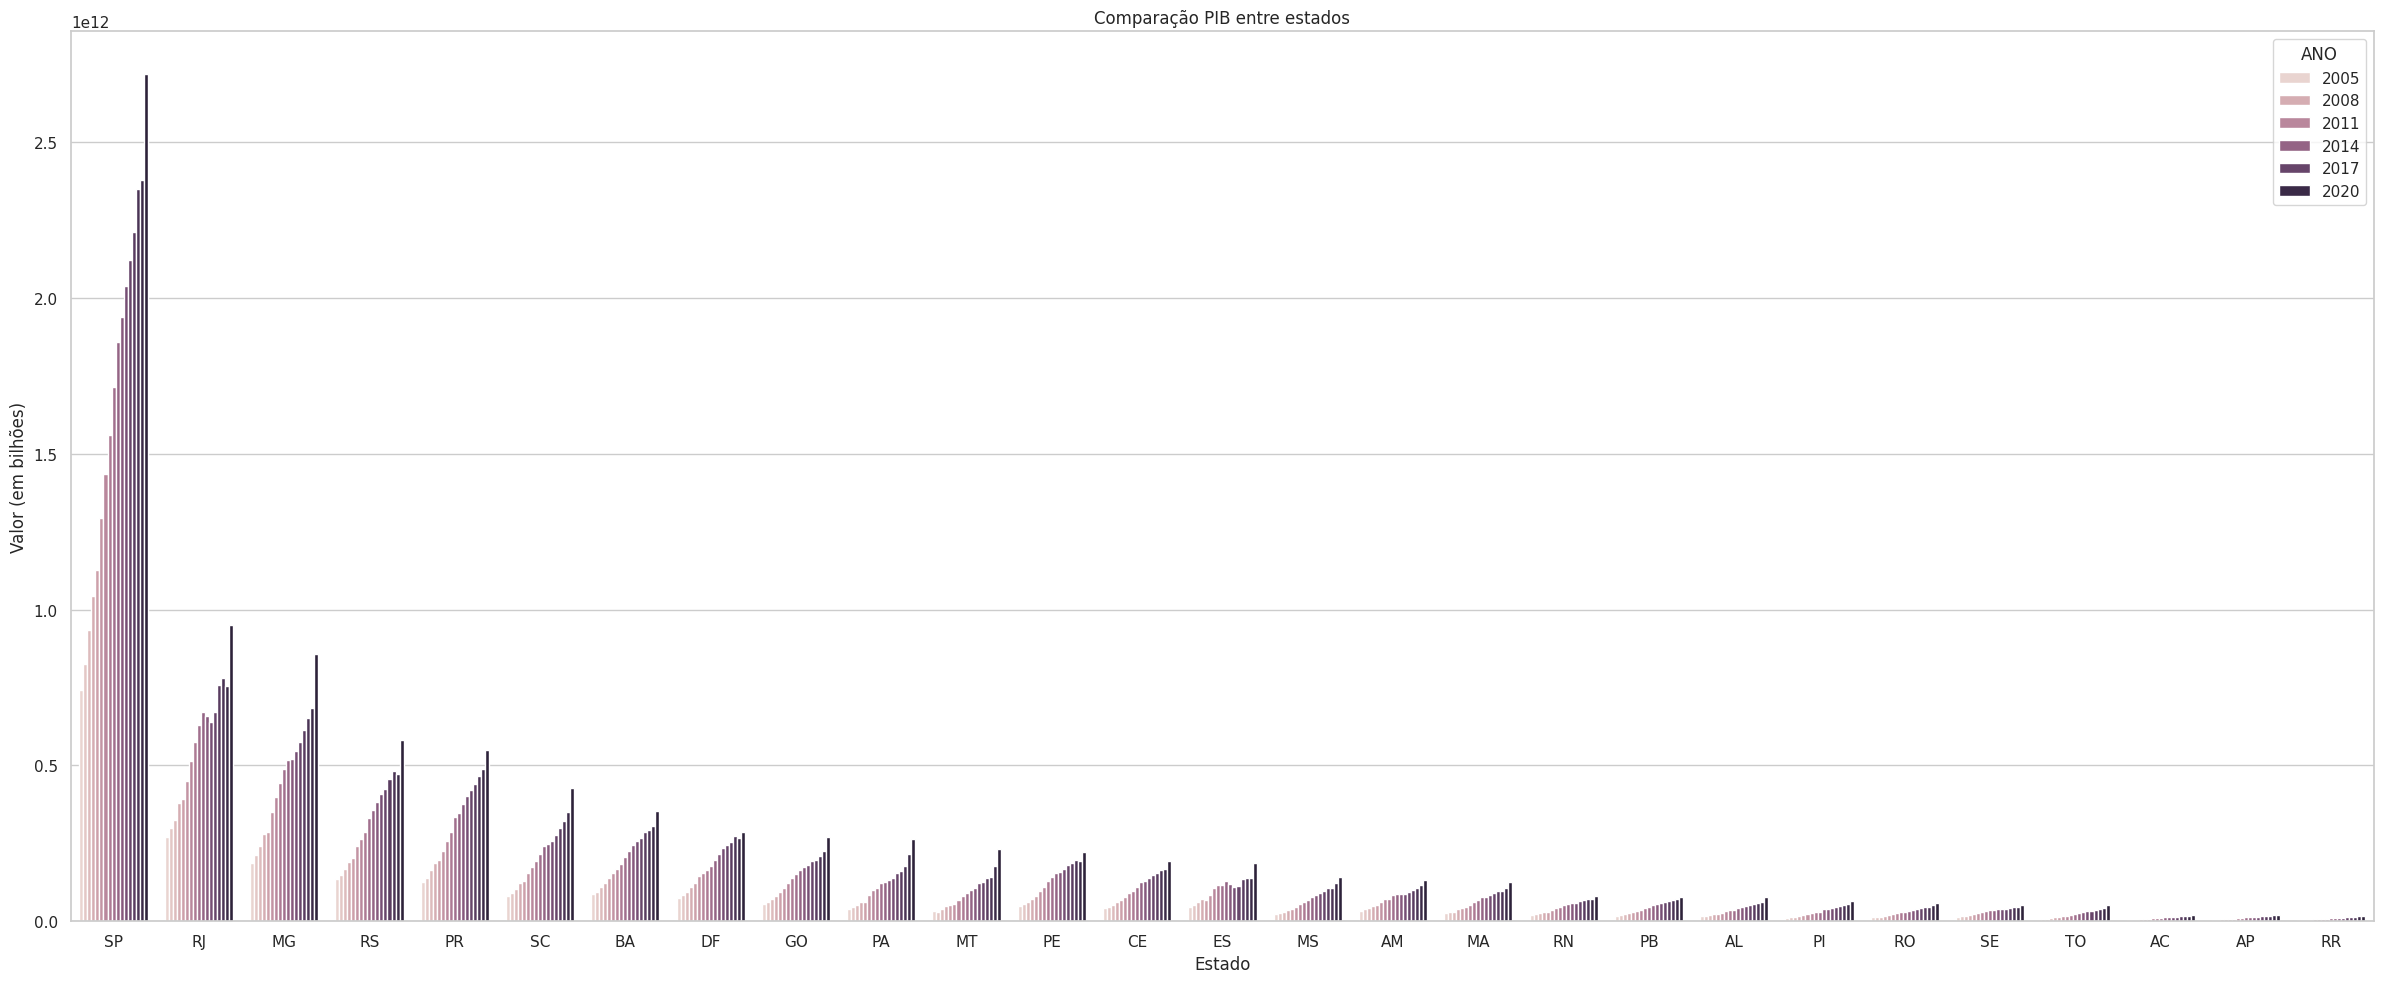

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ordernação por valor e estado
df_pib = df_pib.sort_values(by=['VALOR', 'SIGLA'], ascending=[False, True])


# Configurando estilo
sns.set(style="whitegrid")

# Configurando dimenções
plt.figure(figsize=(24, 10))

# Criando as barras
sns.barplot(x='SIGLA', y='VALOR', hue='ANO', data=df_pib)

# Rótulos e título
plt.xlabel('Estado')
plt.ylabel('Valor (em bilhões)')
plt.title('Comparação PIB entre estados')

# Plotando
plt.tight_layout()
plt.show()


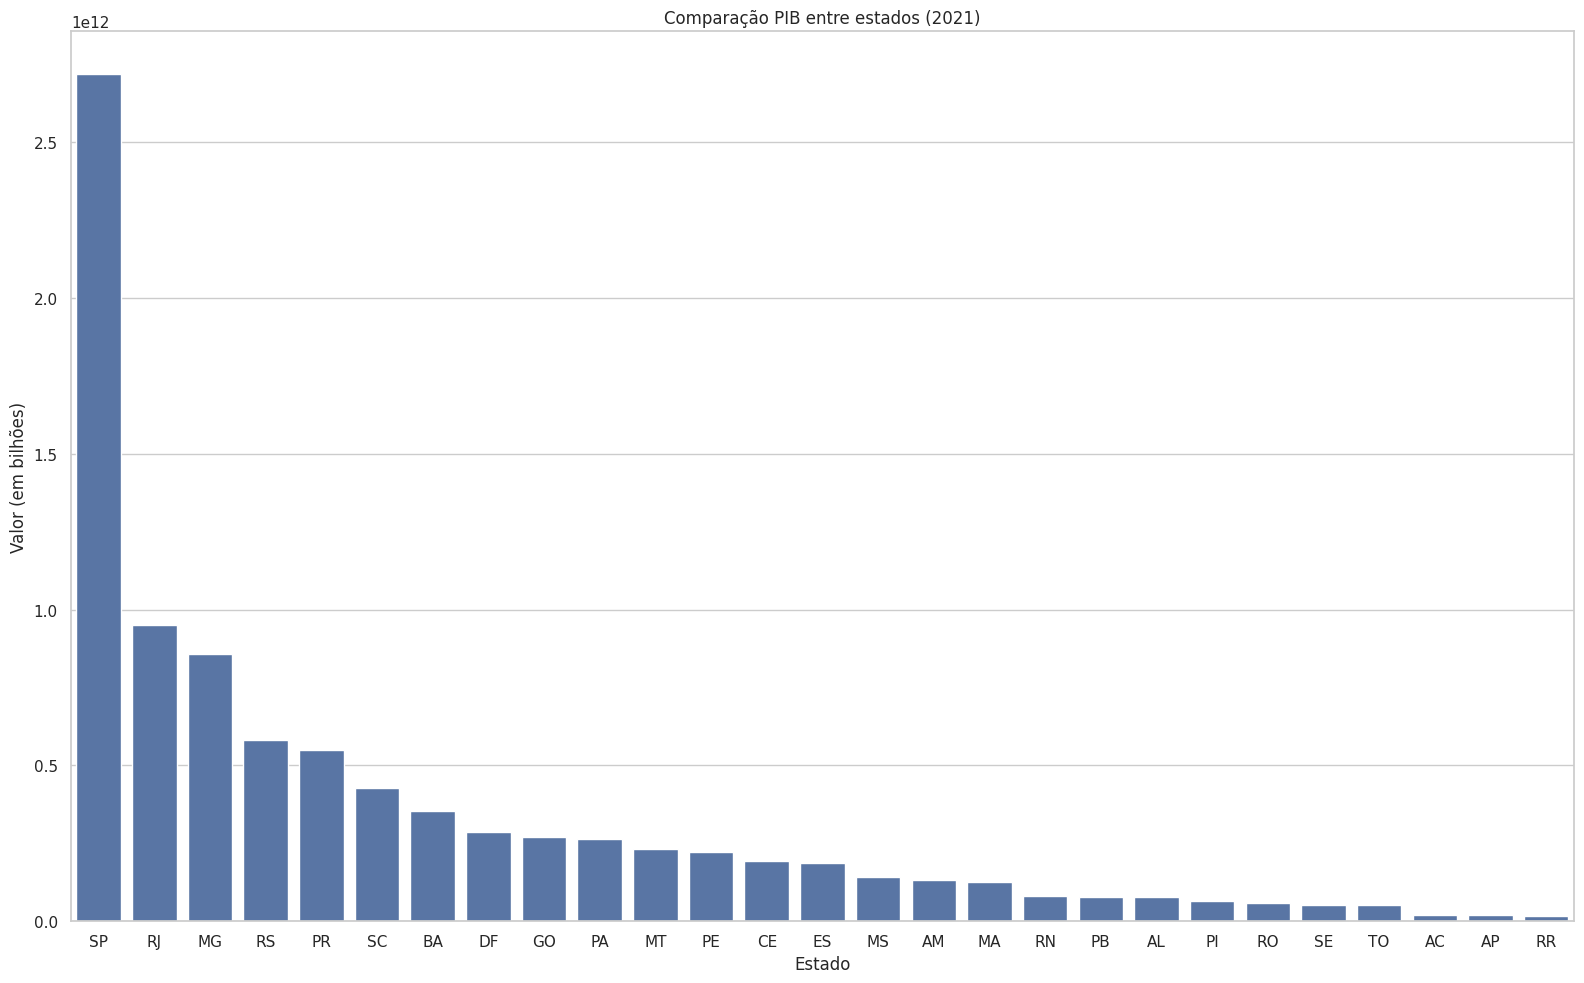

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pib_2021 = df_pib[df_pib['ANO'] == 2021]

# Ordernação por valor e estado
df_pib_2021 = df_pib_2021.sort_values(by=['VALOR', 'SIGLA'], ascending=[False, True])

# Configurando estilo
sns.set(style="whitegrid")

# Configurando dimenções
plt.figure(figsize=(16, 10))

# Criando as barras
sns.barplot(x='SIGLA', y='VALOR', data=df_pib_2021)

# Rótulos e título
plt.xlabel('Estado')
plt.ylabel('Valor (em bilhões)')
plt.title('Comparação PIB entre estados (2021)')

# Plotando
plt.tight_layout()
plt.show()


# População

Aqui os dados foram coletados em CSV do IBGE e simulamos que estes dados estariam diponíveis em um drive para coleta.

In [32]:
import pandas as pd
import requests

file_id = '1xc40YIHHr_d9kQWjZ9i5eLE_OVzI701c'
url = f'https://drive.google.com/uc?export=download&id={file_id}'

response = requests.get(url)
with open('populacao.xlsx', 'wb') as f:
    f.write(response.content)

# Como o arquivo apresentar multiplas linhas acima do cabeçalho, foi necessário pular 4 linhas
df_pop = pd.read_excel('populacao.xlsx', header=1, skiprows=4, engine='openpyxl')

In [33]:
df_pop.head()

,IDADE,SEXO,CÓD.,SIGLA,LOCAL,2000,2001,2002,2003,2004,...,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070
0,0,Ambos,0,BR,Brasil,3423475,3347313,3274356,3212295,3163041,...,1615589,1597609,1580751,1564427,1549026,1534801,1521584,1509151,1497237,1485716
1,1,Ambos,0,BR,Brasil,3450022,3406966,3332612,3261091,3200484,...,1634395,1614666,1596716,1579885,1563579,1548205,1534002,1520805,1508394,1496496
2,2,Ambos,0,BR,Brasil,3461038,3444450,3401900,3327924,3256791,...,1655206,1633932,1614217,1596273,1579457,1563166,1547800,1533609,1520415,1508015
3,3,Ambos,0,BR,Brasil,3469109,3458052,3441638,3399284,3325501,...,1676639,1654738,1633474,1613776,1595841,1579039,1562761,1547399,1533216,1520035
4,4,Ambos,0,BR,Brasil,3477903,3466901,3455987,3439662,3397467,...,1697627,1676166,1654275,1633030,1613338,1595416,1578625,1562356,1547006,1532831


In [34]:
df_pop = df_pop[(df_pop['SEXO'] == 'Ambos') & (~df_pop['SIGLA'].isin(['CO', 'ND', 'NO', 'SD', 'SU', 'BR']))]

In [35]:
df_pop.head()

,IDADE,SEXO,CÓD.,SIGLA,LOCAL,2000,2001,2002,2003,2004,...,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070
1638,0,Ambos,11,RO,Rondônia,32024,31694,31313,30890,30405,...,13507,13326,13152,12984,12825,12675,12534,12399,12274,12152
1639,1,Ambos,11,RO,Rondônia,32122,31704,31410,31070,30679,...,13661,13471,13291,13118,12951,12793,12644,12504,12370,12246
1640,2,Ambos,11,RO,Rondônia,32128,31938,31549,31270,30944,...,13832,13629,13442,13262,13091,12924,12767,12619,12480,12347
1641,3,Ambos,11,RO,Rondônia,32072,31966,31791,31420,31160,...,14009,13802,13600,13415,13235,13065,12899,12743,12596,12458
1642,4,Ambos,11,RO,Rondônia,32016,31909,31820,31662,31307,...,14183,13980,13774,13574,13391,13211,13041,12877,12721,12575


In [36]:
df_pop = df_pop.drop(columns=['IDADE', 'CÓD.', 'SEXO', 'LOCAL'])

In [37]:
df_pop.head()

,SIGLA,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070
1638,RO,32024,31694,31313,30890,30405,29885,28864,27880,27344,...,13507,13326,13152,12984,12825,12675,12534,12399,12274,12152
1639,RO,32122,31704,31410,31070,30679,30235,29752,28762,27800,...,13661,13471,13291,13118,12951,12793,12644,12504,12370,12246
1640,RO,32128,31938,31549,31270,30944,30573,30154,29694,28718,...,13832,13629,13442,13262,13091,12924,12767,12619,12480,12347
1641,RO,32072,31966,31791,31420,31160,30850,30497,30096,29648,...,14009,13802,13600,13415,13235,13065,12899,12743,12596,12458
1642,RO,32016,31909,31820,31662,31307,31063,30770,30432,30043,...,14183,13980,13774,13574,13391,13211,13041,12877,12721,12575


In [38]:
# Agregando por sigla
df_pop = df_pop.groupby('SIGLA', as_index=False).sum()

In [39]:
# Transpondo Anos para coluna ano
df_pop = df_pop.melt(id_vars=['SIGLA'], var_name='ANO', value_name='VALOR')

In [40]:
# Ano para inteiro
df_pop['ANO'] = df_pop['ANO'].astype(int)

In [41]:
# Anos até 2025
df_pop = df_pop[df_pop['ANO'] <= ano_atual]

In [42]:
df_pop.head()

,SIGLA,ANO,VALOR
0,AC,2000,587326
1,AL,2000,2882661
2,AM,2000,2850718
3,AP,2000,500966
4,BA,2000,13220667


## Plotando Gráfico

In [43]:
df_pop.head()

,SIGLA,ANO,VALOR
0,AC,2000,587326
1,AL,2000,2882661
2,AM,2000,2850718
3,AP,2000,500966
4,BA,2000,13220667


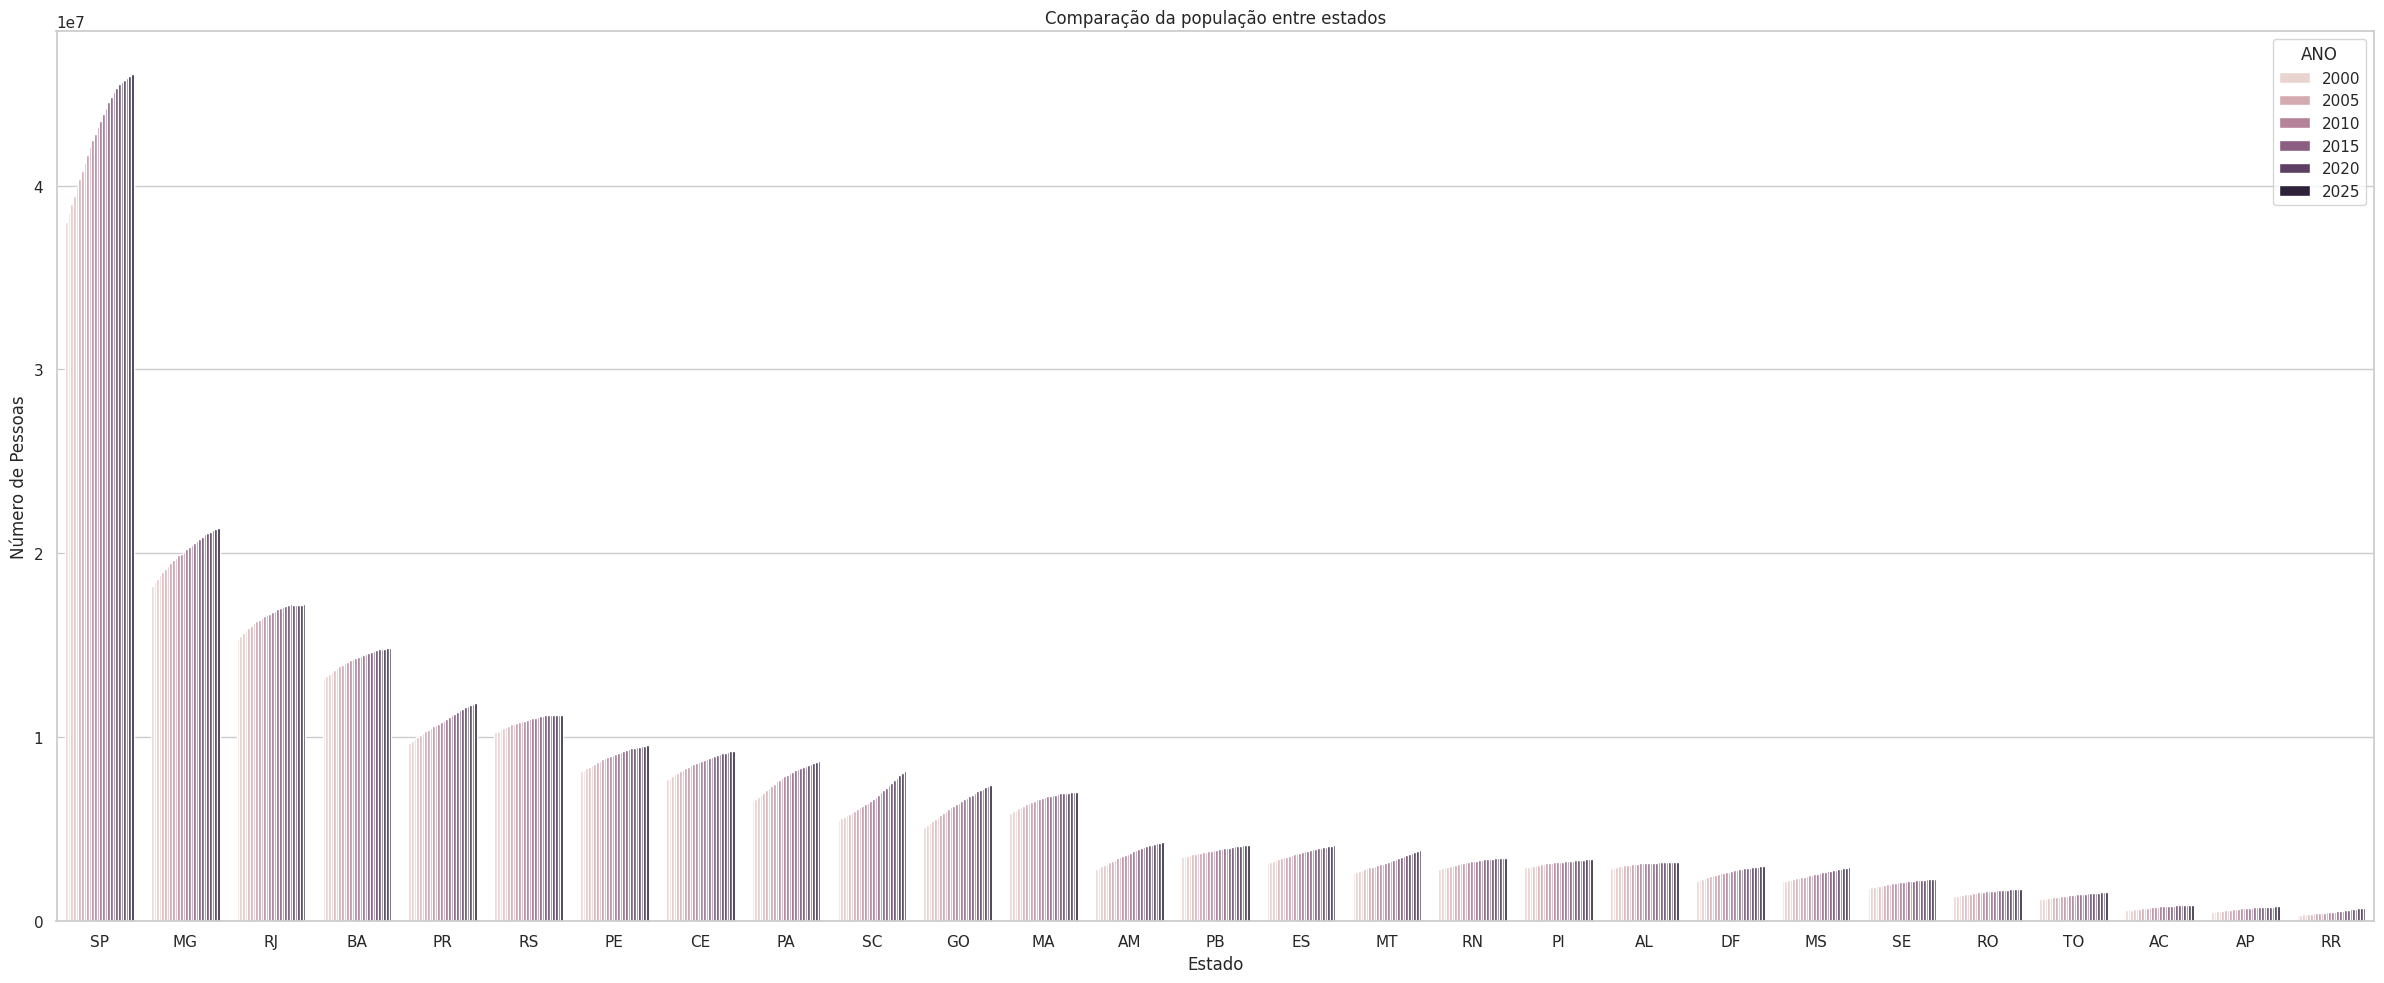

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ordernação por valor e estado
df_pop = df_pop.sort_values(by=['VALOR', 'SIGLA'], ascending=[False, True])

# Configurando estilo
sns.set(style="whitegrid")

# Configurando dimenções
plt.figure(figsize=(24, 10))

# Criando as barras
sns.barplot(x='SIGLA', y='VALOR', hue='ANO', data=df_pop)

# Rótulos e título
plt.xlabel('Estado')
plt.ylabel('Número de Pessoas')
plt.title('Comparação da população entre estados')

# Plotando
plt.tight_layout()
plt.show()

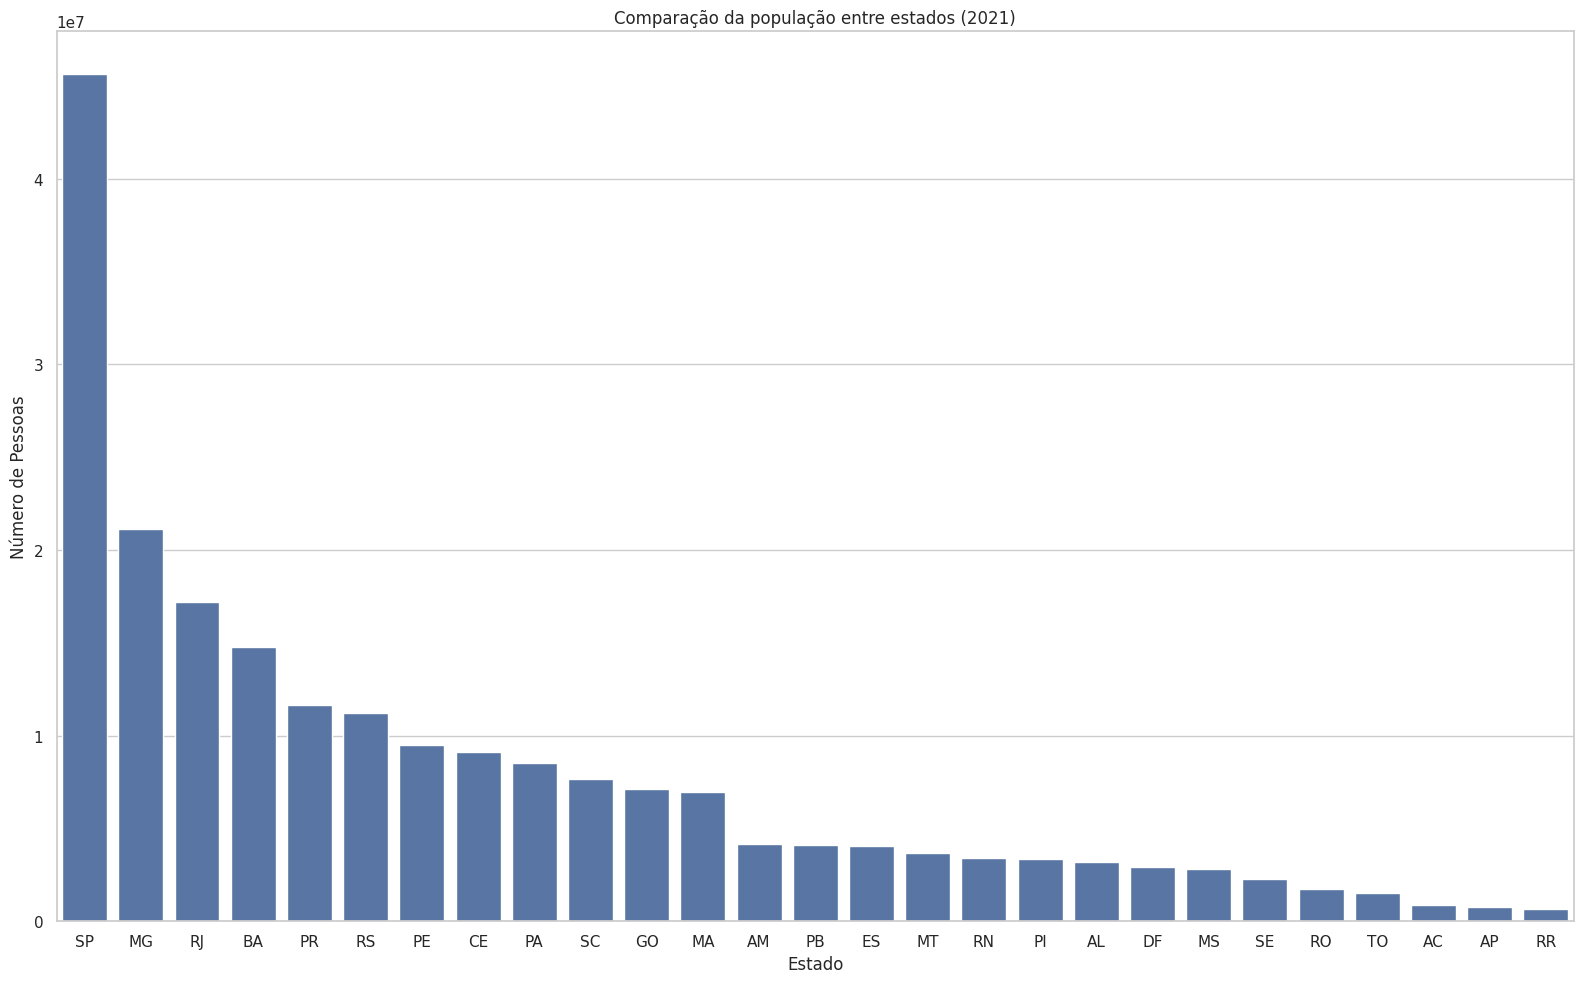

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pop_2021 = df_pop[df_pop['ANO'] == 2021]

# Ordernação por valor e estado
df_pop_2021 = df_pop_2021.sort_values(by=['VALOR', 'SIGLA'], ascending=[False, True])

# Configurando estilo
sns.set(style="whitegrid")

# Configurando dimenções
plt.figure(figsize=(16, 10))

# Criando as barras
sns.barplot(x='SIGLA', y='VALOR', data=df_pop_2021)

# Rótulos e título
plt.xlabel('Estado')
plt.ylabel('Número de Pessoas')
plt.title('Comparação da população entre estados (2021)')

# Plotando
plt.tight_layout()
plt.show()

# PIB x POPULAÇÃO

In [46]:
df_pib[(df_pib['ANO'] == '2020') & (df_pib['SIGLA'] == 'SP')].head()

,SIGLA,ANO,VALOR


In [47]:
df_pop[(df_pop['ANO'] == '2020') & (df_pop['SIGLA'] == 'SP')].head()

,SIGLA,ANO,VALOR


In [48]:
# dividir os valores da tabela pib pelos valores da tabela população, resultando na criação de uma tabela de pib per capta

tabela_pib_per_capta = pd.merge(df_pib, df_pop, on=['SIGLA', 'ANO'], how='inner', suffixes=('_PIB', '_POP'))
tabela_pib_per_capta.head()

,SIGLA,ANO,VALOR_PIB,VALOR_POP
0,SP,2021,2719751231000,45651915
1,SP,2020,2377638980000,45523191
2,SP,2019,2348338000000,45306139
3,SP,2018,2210561949000,45062167
4,SP,2017,2120761635000,44809066


In [49]:
tabela_pib_per_capta['PIB_PER_CAPTA'] = tabela_pib_per_capta['VALOR_PIB'] / tabela_pib_per_capta['VALOR_POP']
tabela_pib_per_capta.head()

,SIGLA,ANO,VALOR_PIB,VALOR_POP,PIB_PER_CAPTA
0,SP,2021,2719751231000,45651915,59575.841035
1,SP,2020,2377638980000,45523191,52229.180946
2,SP,2019,2348338000000,45306139,51832.666650
3,SP,2018,2210561949000,45062167,49055.828784
4,SP,2017,2120761635000,44809066,47328.851599


## Plotando gráficos

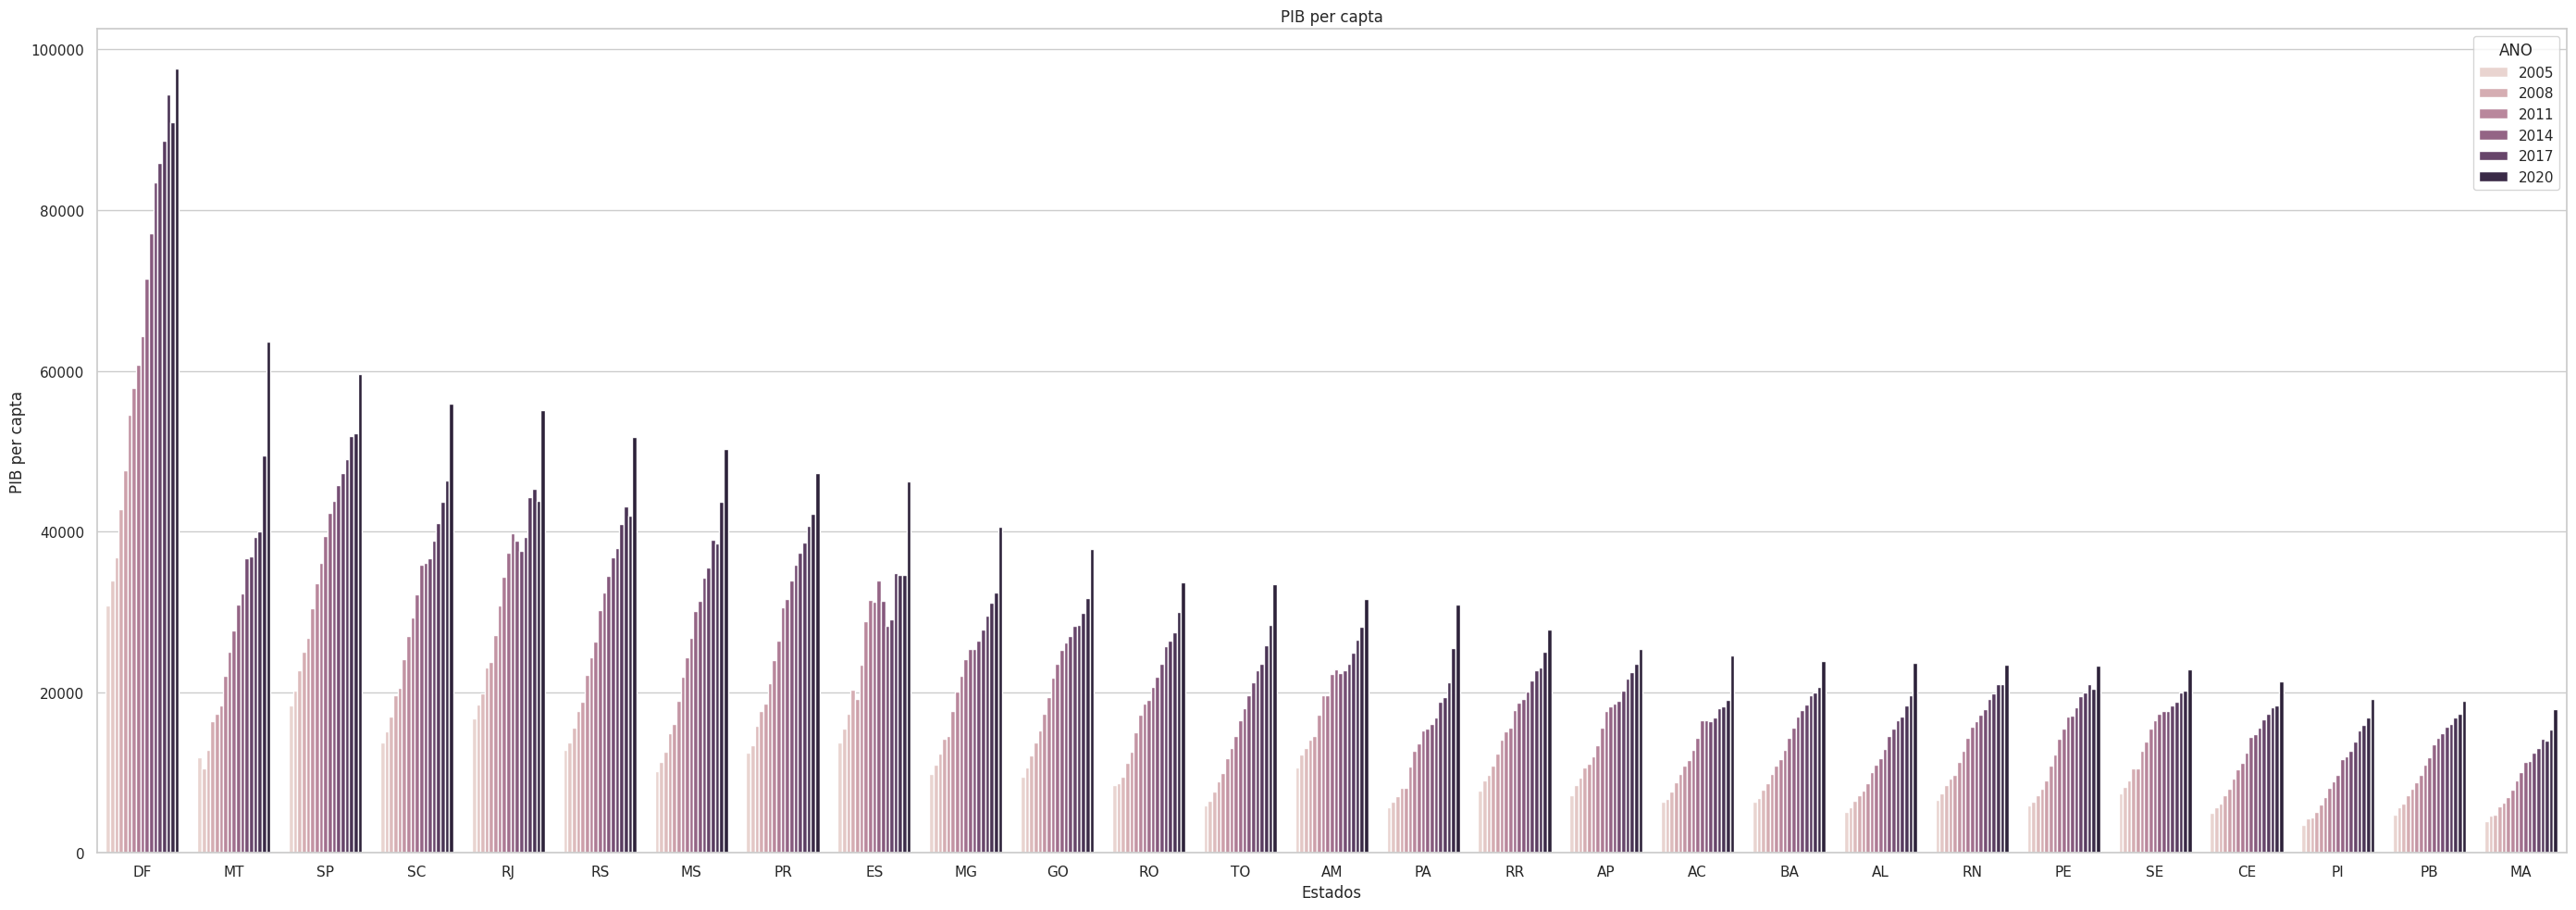

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ordernação por valor e estado
tabela_pib_per_capta = tabela_pib_per_capta.sort_values(by=['PIB_PER_CAPTA', 'SIGLA'], ascending=[False, True])

# Configurando estilo
sns.set(style="whitegrid")

# Configurando dimenções
plt.figure(figsize=(28, 10))

# Criando as barras
sns.barplot(x='SIGLA', y='PIB_PER_CAPTA', hue='ANO', data=tabela_pib_per_capta)

# Rótulos e título
plt.xlabel('Estados')
plt.ylabel('PIB per capta')
plt.title('PIB per capta')

# Plotando
plt.tight_layout()
plt.show()

# ML

In [51]:
tabela_pib_per_capta_rs = tabela_pib_per_capta[tabela_pib_per_capta['SIGLA'] == 'RS']
tabela_pib_per_capta_rs

,SIGLA,ANO,VALOR_PIB,VALOR_POP,PIB_PER_CAPTA
30,RS,2021,581283677000,11227789,51771.873964
40,RS,2019,482464177000,11194346,43098.915917
41,RS,2020,470941846000,11220286,41972.356676
43,RS,2018,457293958000,11167531,40948.528193
48,RS,2017,423270047000,11141074,37991.853119
50,RS,2016,408789528000,11109776,36795.478865
54,RS,2015,381992601000,11070711,34504.793866
57,RS,2014,357816424000,11027344,32448.105727
63,RS,2013,332292726000,10985031,30249.593834
70,RS,2012,287587019000,10944672,26276.440171


In [52]:
tabela_pib_per_capta_rs['ANO'].values

array([2021, 2019, 2020, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011,
       2010, 2009, 2008, 2007, 2006, 2005])

In [53]:
tabela_pib_per_capta_rs['ANO'].values.reshape(-1, 1)

array([[2021],
       [2019],
       [2020],
       [2018],
       [2017],
       [2016],
       [2015],
       [2014],
       [2013],
       [2012],
       [2011],
       [2010],
       [2009],
       [2008],
       [2007],
       [2006],
       [2005]])

In [54]:
X = tabela_pib_per_capta_rs['ANO'].values.reshape(-1, 1)
X

array([[2021],
       [2019],
       [2020],
       [2018],
       [2017],
       [2016],
       [2015],
       [2014],
       [2013],
       [2012],
       [2011],
       [2010],
       [2009],
       [2008],
       [2007],
       [2006],
       [2005]])

In [55]:
tabela_pib_per_capta_rs['PIB_PER_CAPTA'].values

array([51771.87396379, 43098.91591702, 41972.35667611, 40948.52819303,
       37991.85311937, 36795.47886474, 34504.79386554, 32448.105727  ,
       30249.59383365, 26276.44017107, 24298.42158047, 22174.73698143,
       18842.31464411, 17615.92759896, 15627.24414663, 13797.75153512,
       12817.75794932])

In [56]:
y = tabela_pib_per_capta_rs['PIB_PER_CAPTA'].values

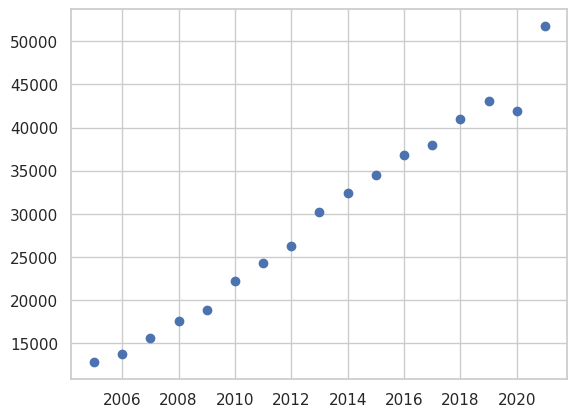

In [57]:
plt.scatter(tabela_pib_per_capta_rs['ANO'].values, tabela_pib_per_capta_rs['PIB_PER_CAPTA'].values)

In [58]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [59]:
lr.fit(X, y)

LinearRegression()

In [60]:
lr.coef_, lr.intercept_

(array([2297.5318318]), np.float64(-4595447.336534735))

In [61]:
y_predicts = lr.predict(X)
y_predicts

array([47864.49552303, 43269.43185944, 45566.96369123, 40971.90002764,
       38674.36819585, 36376.83636405, 34079.30453226, 31781.77270046,
       29484.24086867, 27186.70903687, 24889.17720508, 22591.64537328,
       20294.11354149, 17996.58170969, 15699.0498779 , 13401.5180461 ,
       11103.98621431])

In [62]:
import numpy as np

anos_futuros = np.array([2022, 2023, 2024, 2025]).reshape(-1, 1)
previsoes = lr.predict(anos_futuros)

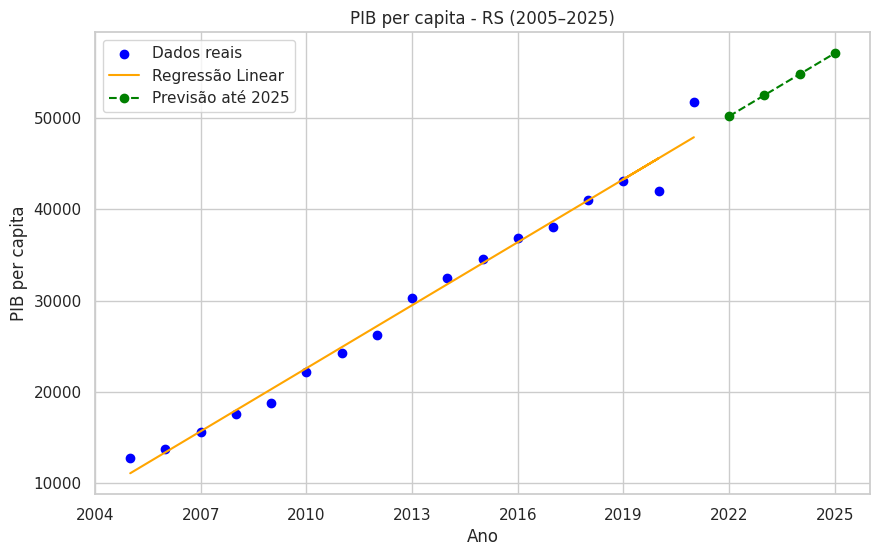

In [63]:
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Dados reais')
plt.plot(X, y_predicts, color='orange', label='Regressão Linear')
plt.plot(anos_futuros, previsoes, color='green', linestyle='--', marker='o', label='Previsão até 2025')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel('Ano')
plt.ylabel('PIB per capita')
plt.title('PIB per capita - RS (2005–2025)')
plt.legend()
plt.grid(True)
plt.savefig('grafico.png')
plt.show()